# Chapter 4: Geometry operations
### Prerequisites

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import geopandas as gpd
import topojson as tp
import rasterio
import rasterio.plot
import rasterio.warp
import rasterio.mask

In [ ]:
data_path = "F:\\books\\geocompy-main\\data\\"
output_path = "F:\\books\\geocompy-main\\output\\"

seine = gpd.read_file(data_path + 'seine.gpkg')
us_states = gpd.read_file(data_path + 'us_states.gpkg')
nz = gpd.read_file(data_path + 'nz.gpkg')
src = rasterio.open(data_path + 'dem.tif')
src_elev = rasterio.open(output_path + 'elev.tif')

## 4.2 Geometric operations on vector data
### 4.2.1 Simplication

In [ ]:
seine_simp = seine.simplify(tolerance=2000)

fig, ax = plt.subplots(1, 2)
seine.plot(ax=ax[0], color='blue', edgecolor='black')
seine_simp.plot(ax=ax[1], color='red', edgecolor='black')

In [ ]:
print(f'Original: {sys.getsizeof(seine)} bytes')
print(f'Simplified: {sys.getsizeof(seine_simp)} bytes')

In [ ]:
us_states9311 = us_states.to_crs(epsg=9311)
us_states_simp1 = us_states9311.simplify(100_000)

topo = tp.Topology(us_states9311, prequantize=False)
us_states_simp2 = topo.toposimplify(100_000).to_gdf()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
us_states9311.plot(ax=ax[0], color='lightgrey', edgecolor='black')
us_states_simp1.plot(ax=ax[1], color='red', edgecolor='black')
us_states_simp2.plot(ax=ax[2], color='blue', edgecolor='black')

### 4.2.2 Centroids

In [ ]:
nz_centroid = nz.centroid
seine_centroid = seine.centroid

nz_pos = nz.representative_point()
seine_pos = seine.representative_point()

In [ ]:
base = nz.plot(color='white', edgecolor='lightgrey')
nz_centroid.plot(ax=base, color='red', markersize=5)
nz_pos.plot(ax=base, color='blue', markersize=5)

In [ ]:
base = seine.plot(color='grey')
seine_centroid.plot(ax=base, color='red', markersize=5)
seine_pos.plot(ax=base, color='blue', markersize=5)

### 4.2.3 Buffers

In [ ]:
seine_buff_5km = seine.buffer(5_000)
seine_buff_50km = seine.buffer(50_000)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
seine_buff_5km.plot(ax=ax[0], color='none', edgecolor=['blue', 'red', 'green'], linewidth=2)
seine_buff_50km.plot(ax=ax[1], color='none', edgecolor=['blue', 'red', 'green'], linewidth=2)

In [ ]:
seine_buff_5km = seine.copy()
seine_buff_5km.geometry = seine.buffer(5000)
seine_buff_5km

In [ ]:
seine['geometry_5km'] = seine.buffer(5000)
seine

In [ ]:
seine = seine.set_geometry('geometry_5km')
seine.plot(color=['blue', 'red', 'green'], edgecolor=['blue', 'red', 'green'], linewidth=2)

In [ ]:
seine = seine.set_geometry('geometry')
seine = seine.drop('geometry_5km', axis=1)
seine

### Affine transformations

In [ ]:
nz_shift = nz.translate(0, 100_000)

base = nz.plot(color='white', edgecolor='lightgrey')
nz_shift.plot(ax=base, color='red', edgecolor='black')

In [ ]:
nz_scale = nz.scale(0.5, 0.5, origin='centroid')
base = nz.plot(color='white', edgecolor='lightgrey')
nz_scale.plot(ax=base, color='red', edgecolor='black')

In [ ]:
nz_rotate = nz.rotate(-30, origin='centroid')
base = nz.plot(color='white', edgecolor='lightgrey')
nz_shift.plot(ax=base, color='red', edgecolor='black')

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
nz.plot(ax=ax[0], color='white', edgecolor='lightgrey')
nz_shift.plot(ax=ax[0], color='green', edgecolor='lightgrey')
ax[0].set_title('Shift')
nz.plot(ax=ax[1], color='white', edgecolor='lightgrey')
nz_rotate.plot(ax=ax[1], color='red', edgecolor='black')
ax[1].set_title('Rotate')
nz.plot(ax=ax[2], color='white', edgecolor='lightgrey')
nz_scale.plot(ax=ax[2], color='blue', edgecolor='black')
ax[2].set_title('Scale')

### 4.2.5 Pairwise geometry-generating operations

In [ ]:
x = shapely.Point((0, 0)).buffer(1)
y = shapely.Point((1, 0)).buffer(1)
shapely.GeometryCollection([x, y])

In [ ]:
x.intersection(y)

In [ ]:
x.difference(y)

In [ ]:
x.union(y)

In [ ]:
x.symmetric_difference(y)

In [ ]:
geom1 = gpd.GeoSeries(x)
geom2 = geom1.translate(0, 1)
geom3 = geom1.translate(0, 2)
geom = pd.concat([geom1, geom2, geom3])
geom

In [ ]:
fig, ax = plt.subplots()
geom.plot(ax=ax, color='#00000030', edgecolor='black')
gpd.GeoSeries(y).plot(ax=ax, color='red', edgecolor='black', alpha=0.3)


In [ ]:
geom_inter_y = geom.intersection(y)
geom_inter_y

In [ ]:
geom_inter_y.plot(color = "#00000030", edgecolor='black')

### 4.2.6 Subsetting vs. clipping

In [ ]:
bounds = x.union(y).bounds
bounds

In [ ]:
np.random.seed(1)
n = 10
coords_x = np.random.uniform(bounds[0], bounds[2], n)
coords_y = np.random.uniform(bounds[1], bounds[3], n)
coords = list(zip(coords_x, coords_y))
coords

In [ ]:
pnt = [shapely.Point(i) for i in coords]
pnt = gpd.GeoSeries(pnt)
pnt

In [ ]:
base = pnt.plot(color='none', edgecolor='black')
gpd.GeoSeries(x).plot(ax=base, color='red', edgecolor='black', alpha=0.3)
gpd.GeoSeries(y).plot(ax=base, color='blue', edgecolor='black', alpha=0.3)
                

In [ ]:
sel = pnt.intersects(x.intersection(y))
pnt1 = pnt[sel]
pnt1

In [ ]:
pnt2 = pnt.intersection(x.intersection(y))
pnt2

In [ ]:
base = pnt.plot(color='none', edgecolor='black')
gpd.GeoSeries(x).plot(ax=base, color='red', edgecolor='black', alpha=0.3)
gpd.GeoSeries(y).plot(ax=base, color='blue', edgecolor='black', alpha=0.3)
pnt2.plot(ax=base, color='green')

In [ ]:
base = pnt.plot(color='none', edgecolor='black')
gpd.GeoSeries(x).plot(ax=base, color='red', edgecolor='black', alpha=0.3)
gpd.GeoSeries(y).plot(ax=base, color='blue', edgecolor='black', alpha=0.3)
pnt1.plot(ax=base, color='green')

In [ ]:
pnt2 = pnt2[~pnt2.is_empty]
pnt2

### 4.2.7 Geometry unions

In [ ]:
regions = us_states[['REGION', 'geometry', 'total_pop_15']] \
    .dissolve(by='REGION', aggfunc='sum').reset_index()
regions

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(9, 2.5))
us_states.plot(
    ax=ax[0],
    column='total_pop_15',
    edgecolor='black',
    legend=True
)
regions.plot(
    ax=ax[1],
    column='total_pop_15',
    edgecolor='black',
    legend=True
)

In [ ]:
us_west = us_states[us_states['REGION'] == 'West']
us_west_union = us_west.geometry.union_all()
us_west_union

In [ ]:
sel = (us_states['REGION'] == 'West') | (us_states['NAME'] == 'Texas')
texas_union = us_states[sel]
texas_union = texas_union.union_all()
texas_union

In [ ]:
us_west = us_states[us_states['REGION'] == 'West']
texas = us_states[us_states['NAME'] == 'Texas']
texas_union = pd.concat([us_west, texas]).union_all()
texas_union

### 4.2.8 Type transformations

In [ ]:
multipoint = shapely.MultiPoint([(1, 1), (3, 3), (5, 1)])
multipoint

In [ ]:
linestring = shapely.LineString(multipoint.geoms)
linestring

In [ ]:
polygon = shapely.Polygon(multipoint.geoms)
polygon

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
gpd.GeoSeries(multipoint).plot(ax=ax[0], color='red', edgecolor='black')
gpd.GeoSeries(linestring).plot(ax=ax[1], color='blue', edgecolor='black')
gpd.GeoSeries(polygon).plot(ax=ax[2], color='green', edgecolor='black')

In [ ]:
shapely.MultiPoint(linestring.coords)

In [ ]:
shapely.MultiPoint(polygon.exterior.coords)

In [ ]:
multipolygon = shapely.MultiPolygon([
    polygon,
    shapely.affinity.translate(polygon.centroid.buffer(1.5), 3, 2)
])
multipolygon

In [ ]:
multipolygon.geoms[0]

In [ ]:
multipolygon.geoms[1]

In [ ]:
l1 = shapely.LineString([(1, 5), (4, 3)])
l2 = shapely.LineString([(4, 4), (4, 1)])
l3 = shapely.LineString([(2, 2), (4, 2)])
ml = shapely.MultiLineString([l1, l2, l3])
ml

In [ ]:
geom = gpd.GeoSeries(ml)
geom

In [ ]:
dat = gpd.GeoDataFrame(geometry=geom, data=pd.DataFrame({'id':[1]}))
dat

In [ ]:
list(ml.geoms)

In [99]:
dat1 = dat.explode(index_parts=True).reset_index()
dat1

,level_0,level_1,id,geometry
0,0,0,1,"LINESTRING (1 5, 4 3)"
1,0,1,1,"LINESTRING (4 4, 4 1)"
2,0,2,1,"LINESTRING (2 2, 4 2)"


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
dat.plot(ax=ax[0], column='id', linewidth=7)
dat1.plot(ax=ax[1], column='level_1', linewidth=7)

In [97]:
dat2 = dat1.copy()
dat2.geometry = dat2.geometry.apply(lambda x: shapely.MultiPoint(x.coords))
dat2

,level_0,level_1,id,geometry
0,0,0,1,"MULTIPOINT (1 5, 4 3)"
1,0,1,1,"MULTIPOINT (4 4, 4 1)"
2,0,2,1,"MULTIPOINT (2 2, 4 2)"


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
dat1.plot(ax=ax[0], column='level_1', linewidth=7)
dat2.plot(ax=ax[1], column='level_1', markersize=50)

In [ ]:
dat1.dissolve(by='id').reset_index()

In [104]:
nz_dis1 = nz[['Island', 'Population', 'geometry']] \
    .dissolve(by='Island', aggfunc='sum') \
    .reset_index()
nz_dis1

,Island,geometry,Population
0,North,"MULTIPOLYGON (((1865558.829 5462204.443, 18612...",3671600.0
1,South,"MULTIPOLYGON (((1229729.735 4798718.607, 12299...",1115600.0


In [ ]:
nz_dis2 = nz \
    .groupby('Island') \
    .agg({
        'Population': 'sum',
        'geometry': lambda x: shapely.MultiPolygon(x.explode().to_list())
        }) \
    .reset_index()
nz_dis2 = gpd.GeoDataFrame(nz_dis2).set_geometry('geometry').set_crs(nz.crs)
nz_dis2

<Axes: >

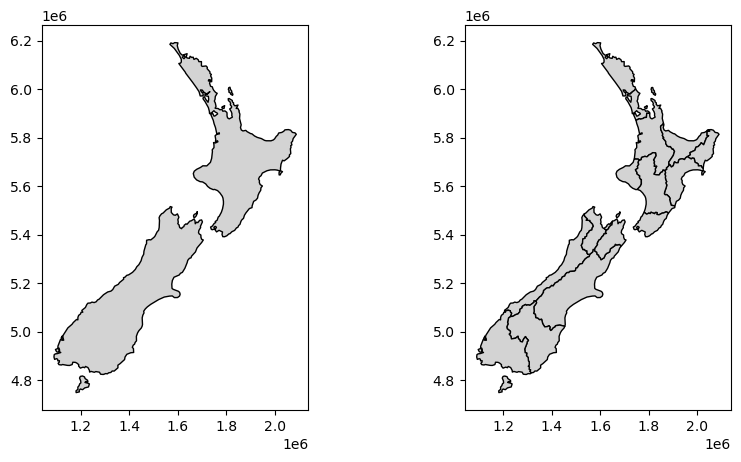

In [107]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
nz_dis1.plot(ax=ax[0], color='lightgrey', edgecolor='black')
nz_dis2.plot(ax=ax[1], color='lightgrey', edgecolor='black')